In [ ]:
!pip install scanpy

In [18]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.6.2
Uninstalling matplotlib-3.6.2:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/matplotlib-3.6.2-py3.8-nspkg.pth
    /usr/local/lib/python3.8/dist-packages/matplotlib-3.6.2.dist-info/*
    /usr/local/lib/python3.8/dist-packages/matplotlib/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.8/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.6.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 31.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency 

In [3]:
import scanpy as sc

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torch.nn as nn

from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal

from torch.utils.data import DataLoader, Dataset

from sklearn.decomposition import PCA

In [4]:
cuda = True
device = torch.device("cuda" if cuda else "cpu")

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **CUSTOM DATASET**

In [6]:
class h5adDataset(Dataset):
    def __init__(self, train=True, raw=False, sample_amount=None):
        self.path = "/content/drive/MyDrive/Colab Notebooks/sad2/projekt/SAD2022Z"
        if train:
            self.path += "/SAD2022Z_Project1_GEX_train.h5ad"
        else:
            self.path += "/SAD2022Z_Project1_GEX_test.h5ad"

        if raw:
            base = sc.read_h5ad(self.path).layers["counts"].X.toarray()
        else:
            base = sc.read_h5ad(self.path).X.toarray()

        if sample_amount is not None:
            base = base[:sample_amount]

        self.root = torch.from_numpy(base).to(device)
        # normalize
        self.root = torch.log1p(self.root)

    def __len__(self):
        return len(self.root)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.root[idx]

# **MODEL**

In [7]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2)
        )
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):
        x1 = self.layers(x)
        mean = self.fc_mean(x1)
        log_var = self.fc_log_var(x1)
        return mean, log_var

    def log_prob(self, z):
        normal_dist = Normal(0, 1)
        return normal_dist.log_prob(z)

In [8]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
        self.dist = None
        
    def construct_dist(self, x_means, hyper_parameter):
        cov_matrix = torch.diag(torch.zeros(x_means.shape[1])+hyper_parameter).to(device)
        # cov_matrix = torch.unsqueeze(cov_matrix, dim=0).expand(x_means.shape[0], x_means.shape[1], x_means.shape[1])
        return MultivariateNormal(x_means, cov_matrix)
        
    def forward(self, x, hyper_parameter, ground_truth=None):
        """Returns means for decoder distribution"""
        x_means = self.layers(x)
        self.dist = self.construct_dist(x_means, hyper_parameter)
        return self.dist.sample()

    def log_prob(self, x):
        return self.dist.log_prob(x)

In [9]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

        self.latent = None

    def reparameterization(self, mean, log_var):
        norm = torch.normal(
            0, 1, size = mean.shape
        ).to(device)

        return mean + torch.exp(0.5*log_var) * norm
                
    def forward(self, x, hyper_parameter):
        mean, log_var = self.Encoder(x)
        sample = self.reparameterization(mean, log_var)

        self.latent = sample
        
        x_hat = self.Decoder(sample, hyper_parameter, x)
        decoder_log_prob = self.Decoder.log_prob(x)
        return x_hat, mean, log_var, decoder_log_prob

    def generate(self, mean, log_var, hyper_parameter):
        sample = self.reparameterization(mean, log_var)
        return self.Decoder(sample, hyper_parameter)

# **PLOT FUNC**

In [10]:
def plot_loss(data):
    fig, ax = plt.subplots()

    loss = ax.scatter(np.arange(len(data)), [i[0] for i in data], c = "blue")
    rec = ax.scatter(np.arange(len(data)), [i[1] for i in data], c = "green")
    reg = ax.scatter(np.arange(len(data)), [i[2] for i in data], c = "red")

    plt.legend((loss, rec, reg),
            ('loss', 'rec', 'reg'),
            fontsize=8)
    
    ax.set_ylabel('Loss')
    plt.xlabel("Epochs")

    # plt.savefig("scatter.png", dpi=1000)
    
    plt.show()

# **LOSS FUNC**

In [11]:
def loss_function(x, x_hat, mean, log_var, decoder_log_prob, beta):
    rec_loss = -torch.sum(decoder_log_prob)
    KLD = -0.5*torch.sum(1 + log_var - torch.exp(log_var) - mean**2)
    return rec_loss + beta*KLD, rec_loss, beta*KLD

# **TRAINING**

In [12]:
dataset_tr = h5adDataset(train=True, sample_amount=1000)
dataset_te = h5adDataset(train=False, sample_amount=100)

BATCH_SIZE = 10

dataloader_tr = DataLoader(dataset_tr, BATCH_SIZE, shuffle=True)
dataloader_te = DataLoader(dataset_te, BATCH_SIZE, shuffle=True)

In [13]:
X_DIM  = 5000
HIDDEN_DIM = 500
LATENT_DIM = 100

EPOCHS = 10
TEST_INTERVAL = 4

SD_HYPER_PARAMETER = 0.07
BETA = 3

In [14]:
encoder = Encoder(input_dim=X_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM)
decoder = Decoder(latent_dim=LATENT_DIM, hidden_dim = HIDDEN_DIM, output_dim = X_DIM)
model = Model(Encoder=encoder, Decoder=decoder).to(device)

optimizer = torch.optim.Adam(model.parameters())

model.train()

training_loss_data = []
testing_loss_data = []

te_iter = iter(dataloader_te)

for epoch in range(EPOCHS):
    overall_training_loss = 0
    overall_training_rec = 0
    overall_training_reg = 0

    for i, x in enumerate(dataloader_tr):
        optimizer.zero_grad()
        x_hat, mean, log_var, decoder_log_prob = model(x, SD_HYPER_PARAMETER)

        loss, rec, reg = loss_function(x, x_hat, mean, log_var, decoder_log_prob, BETA)
        overall_training_loss += loss.item()
        overall_training_rec += rec.item()
        overall_training_reg += reg.item()

        loss.backward()
        optimizer.step()

    if ((epoch+1) % TEST_INTERVAL == 0):
        x_te = next(te_iter)
        x_hat, mean, log_var, decoder_log_prob = model(x_te, SD_HYPER_PARAMETER)
        loss_te, rec, reg = loss_function(x_te, x_hat, mean, log_var, decoder_log_prob, BETA)
        testing_loss_data.append((loss_te.item(), rec.item(), reg.item()))
        print("\tEpoch", i + 1, "Average Testing Loss: ", loss_te.item())

    info_loss = overall_training_loss / (len(dataloader_tr) * BATCH_SIZE)
    info_rec = overall_training_rec / (len(dataloader_tr) * BATCH_SIZE)
    info_reg = overall_training_reg / (len(dataloader_tr) * BATCH_SIZE)

    training_loss_data.append((info_loss, info_rec, info_reg))
    print("\tEpoch", epoch + 1, "Average Loss: ", info_loss)

	Epoch 1 Average Loss:  2288.5276444091796
	Epoch 2 Average Loss:  1591.8489357910157
	Epoch 3 Average Loss:  1495.0546887817384
	Epoch 100 Average Testing Loss:  7260.28955078125
	Epoch 4 Average Loss:  1451.8375712585448
	Epoch 5 Average Loss:  1418.344769897461
	Epoch 6 Average Loss:  1395.384587097168
	Epoch 7 Average Loss:  1373.78556640625
	Epoch 100 Average Testing Loss:  8355.1572265625
	Epoch 8 Average Loss:  1367.685890197754
	Epoch 9 Average Loss:  1338.1993315429688
	Epoch 10 Average Loss:  1344.968809173584


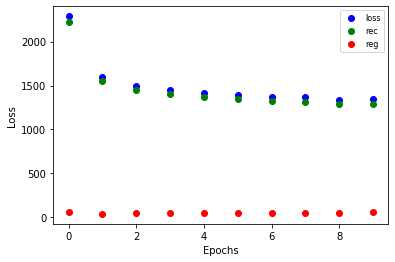

In [19]:
plot_loss(training_loss_data)

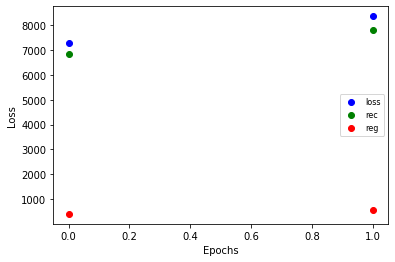

In [20]:
plot_loss(testing_loss_data)

# **PCA**

In [31]:
latent_space = model.latent.cpu().detach().numpy()
print("latent_space shape:", latent_space.shape)

pca = PCA(3)
pca.fit(latent_space)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

latent_space shape: (10, 100)
[0.18516102 0.16902311 0.13144505]
[12.366449 11.81526  10.419392]
